In [2]:
import os
import copy
from datetime import datetime


In [3]:
from mercury_ml.chatbot.services.product_service import ProductServiceFunctions
from mercury_ml.chatbot.services.order_service import OrderServiceFunctions
from mercury_ml.chatbot.services.shipping_service import ShippingServiceFunctions
from mercury_ml.chatbot.services.return_refund_service import ReturnRefundServiceFunctions
import json
from mercury_ml.chatbot.utils.service_utils import *
from mercury_ml.chatbot.utils.prompt_utils import *
from mercury_ml.chatbot.utils.utils import *

from mercury_ml.chatbot.apis.openai import chat_completion_request
from mercury_ml.chatbot.rag.rag_retrieval import RetrievalRAG

2024-05-28 00:42:41,925 [_config.py:load_ssl_context:80] DEBUG - load_ssl_context verify=True cert=None trust_env=True http2=False
2024-05-28 00:42:41,927 [_config.py:load_ssl_context_verify:146] DEBUG - load_verify_locations cafile='/Users/abcom/.pyenv/versions/3.11.0/envs/learn-ai/lib/python3.11/site-packages/certifi/cacert.pem'


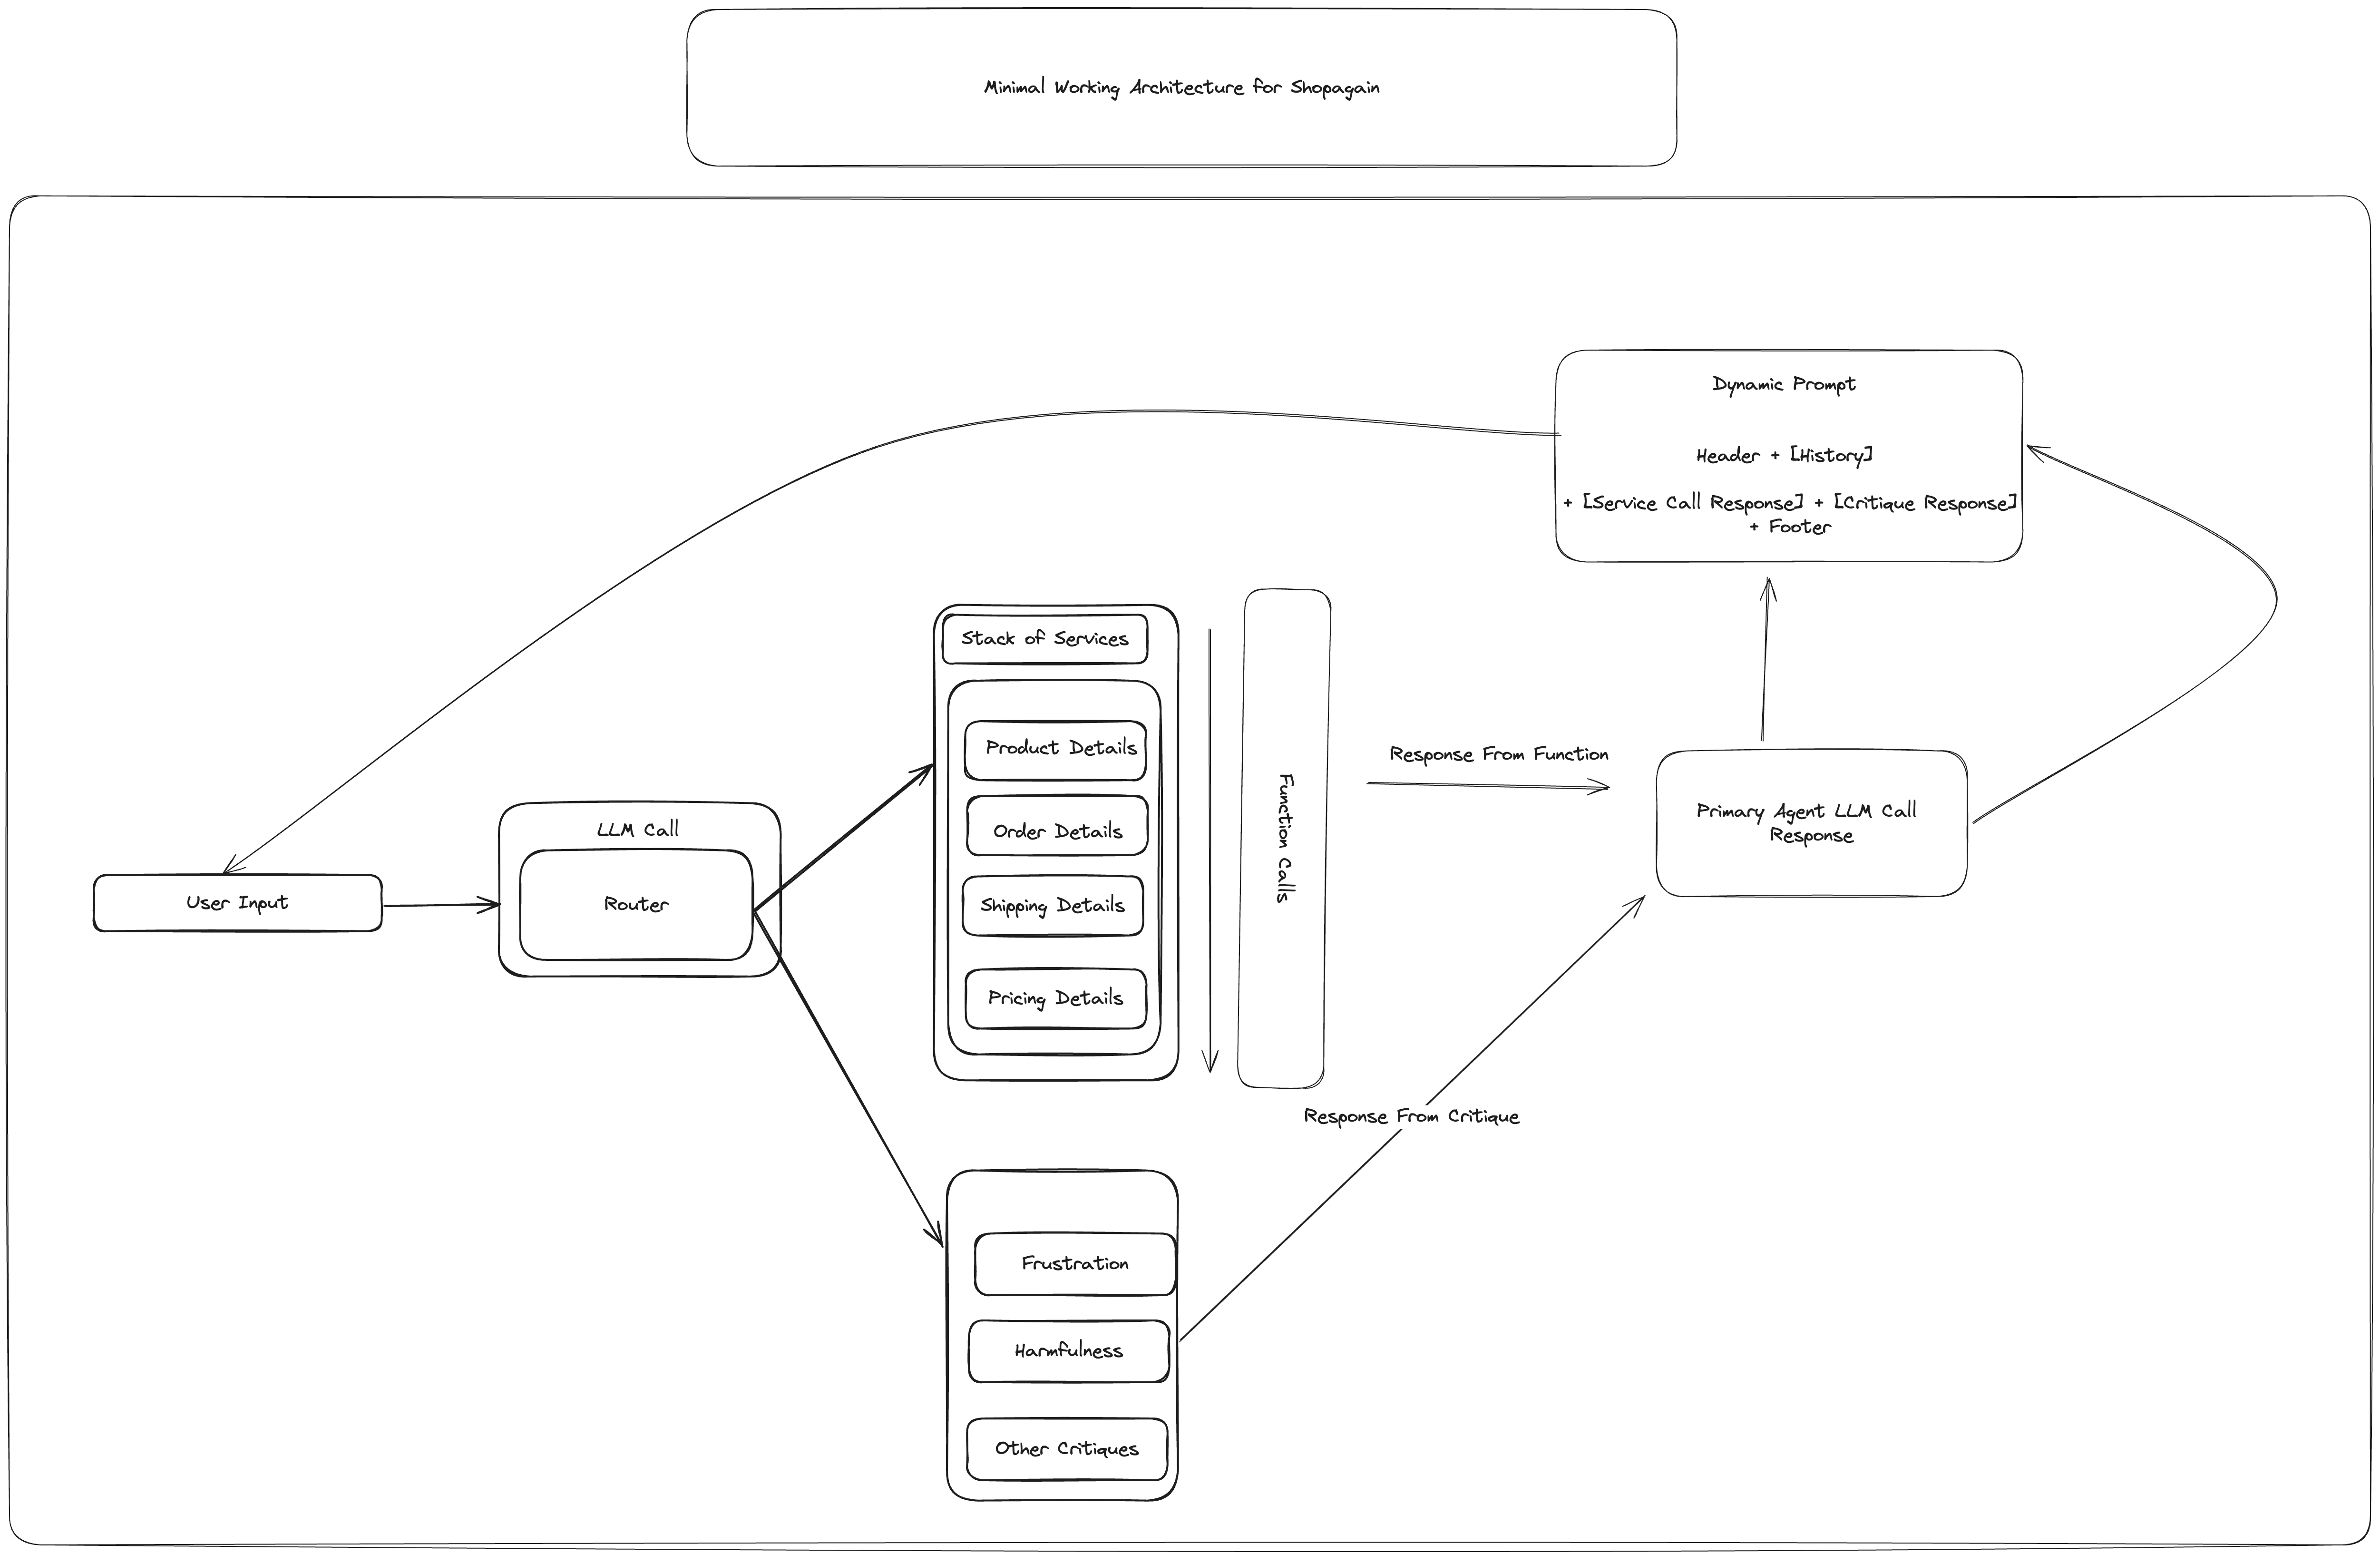

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Load Prompts

In [5]:
import yaml
with open("mercury_ml/chatbot/prompts/service_selector_prompts.yaml", 'r') as f:
    config = yaml.safe_load(f)
    ServiceSelectionRouterBasePrompt = config['ServiceSelectionRouterBasePrompt']

with open("mercury_ml/chatbot/prompts/persona_prompts.yaml", 'r') as f:
    config = yaml.safe_load(f)
    EcommerceBotPrompt = config['EcommerceBotPrompt']
    EcommerceBotAnalyzerPrompt = config['EcommerceBotAnalyzerPrompt']

In [6]:
company_id = '6b0173e7-bd13-4046-b8fa-d5d39240950e'


# Service Functions

In [7]:
# Sample usage
# print(ProductServiceFunctions.get_product_info(product_id='70802'))
print(ProductServiceFunctions.get_product_variants(company_id, product_id='29805'))
# print(get_product_vendor(product_id='71396'))

2024-05-28 00:42:44,301 [ecom_api.py:fetch_product_info:30] DEBUG - data: {'company_id': '6b0173e7-bd13-4046-b8fa-d5d39240950e', 'function_name': 'get_product_info', 'kwargs': {'product_id': '29805'}}


('Other variants available for Product ID 29805:\nID: INDCB01-6, Title: Size 6 cm Diameter, Price: 1350.0\nID: INDCB01RG, Title: Rose Gold/Size 5.5cm Diameter, Price: 1350.0\nID: INDCB01S, Title: Silver/Size 5.5cm Diameter, Price: 1250.0\nID: INDCB01, Title: Golden/Size 5.5cm Diameter, Price: 1350.0', '')


In [8]:
# order_data = fetch_order_info(48377)
# order_data = fetch_order_info_by_user(email='aparna@stardotstar.in')
order_data = OrderServiceFunctions.get_order_status(company_id, mobile='+918698891709')
print(order_data)

2024-05-28 00:42:44,485 [ecom_api.py:fetch_order_info_by_user:73] DEBUG - data: {'company_id': '6b0173e7-bd13-4046-b8fa-d5d39240950e', 'function_name': 'get_last_order_for_user', 'kwargs': {'mobile': '+918698891709'}}


('The status of your order for phone number +918698891709 is placed. The order is currently being processed by our team.', '')


In [9]:
OrderServiceFunctions.get_last_order_date(company_id,mobile='+918698891709')

2024-05-28 00:42:44,661 [ecom_api.py:fetch_order_info_by_user:73] DEBUG - data: {'company_id': '6b0173e7-bd13-4046-b8fa-d5d39240950e', 'function_name': 'get_last_order_for_user', 'kwargs': {'mobile': '+918698891709'}}


('Your last order was placed on 2023-09-06T04:16:11Z.', '')

In [10]:
order_data = ReturnRefundServiceFunctions.replace_product(company_id, mobile='+918698891709')
print(order_data)

2024-05-28 00:42:44,823 [ecom_api.py:fetch_order_info_by_user:73] DEBUG - data: {'company_id': '6b0173e7-bd13-4046-b8fa-d5d39240950e', 'function_name': 'get_last_order_for_user', 'kwargs': {'mobile': '+918698891709'}}


('The product cannot be replaced as the order status is placed.', '')


In [11]:
order_data = ShippingServiceFunctions.get_shipping_status(company_id, mobile='+918698891709')
print(order_data)

2024-05-28 00:42:45,370 [ecom_api.py:fetch_order_info_by_user:73] DEBUG - data: {'company_id': '6b0173e7-bd13-4046-b8fa-d5d39240950e', 'function_name': 'get_last_order_for_user', 'kwargs': {'mobile': '+918698891709'}}


('The status of your order for phone number +918698891709 is placed. The order is currently being processed by our team.', '')


# Utility functions

In [12]:
def print_list(items):
    for index, item in enumerate(items):
        print(f"Index {index}:")
        print(f"{item}\n\n")

def extract_last_json_llm_selector(text: str) -> dict:
    prompt = """Your response will be json. Try to extract "SERVICE_NAME" in json format. service_name are described as:
                1. service name: order_functions
                   service description: contains functions to get_order_status, get_last_order_date, get_recent_order_products

                2. service name: product_functions
                   service description: contains functions to get_product_info, get_product_variants, get_product_vendor, get_product_in_stock_info

                3. service name: shipping_functions
                   service description: contains functions to get_shipping_options, change_shipping_address, get_shipping_policy, get_shipping_status

                4. service name: return_refund_functions
                   service description: contains functions to get_refund_status, get_return_status, get_return_policy, get_refund_policy, replace_product, return_product

                5. service name: pricing_discount_functions
                   service description: contains functions to get_discount_coupon_info, get_promotion_info, get_gift_info

                6. service name: other_functions
                   service description: everything else that does not fit into above 5 services, 
                   For example, contains functions to get_operating_hours_info, get_contact_info, get_other_info

                Your JSON response should be formatted as follows:

                {"service_name": SERVICE_NAME}
    """
    messages = []
    messages.append({"role": "system", "content": prompt})
    messages.append({"role": "user", "content": text})
    chat_response = chat_completion_request(messages)
    try:
        chat_str = chat_response.json()['choices'][0]['message']['content']
        print("chat_str = ",chat_str)
        chat_dict = json.loads(chat_str)
        return chat_dict
    except:
        return {"error": "No complete JSON object found in text"}

In [13]:
chat_str =  '''The updated information in JSON format is:
{
    "service_name": "order_functions",
    "function_name": "get_recent_order_products",
    "parameters": {
        "order_id": "123456789"
    }
}'''

# extract_last_json(chat_str)
extract_last_json_llm_selector(chat_str)

2024-05-28 00:42:46,552 [openai.py:chat_completion_request:39] DEBUG - Request to OpenAI API
2024-05-28 00:42:46,557 [_base_client.py:_build_request:446] DEBUG - Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'role': 'system', 'content': 'Your response will be json. Try to extract "SERVICE_NAME" in json format. service_name are described as:\n                1. service name: order_functions\n                   service description: contains functions to get_order_status, get_last_order_date, get_recent_order_products\n\n                2. service name: product_functions\n                   service description: contains functions to get_product_info, get_product_variants, get_product_vendor, get_product_in_stock_info\n\n                3. service name: shipping_functions\n                   service description: contains functions to get_shipping_options, change_shipping_address, get_shipping_policy, get_shipping_status\n\n      

{'error': 'No complete JSON object found in text'}

# Actual Chat Session

In [14]:
# Using the function
all_service_functions = get_static_methods(OrderServiceFunctions) + \
                       get_static_methods(ProductServiceFunctions) + \
                       get_static_methods(ShippingServiceFunctions) + \
                       get_static_methods(ReturnRefundServiceFunctions)

print(all_service_functions)

['get_last_order_date', 'get_order_status', 'get_recent_order_products', 'manage_order_change_request', 'get_product_info', 'get_product_variants', 'get_product_vendor', 'change_shipping_address', 'get_shipping_policy', 'get_shipping_status', 'get_refund_policy', 'get_refund_status', 'get_return_policy', 'get_return_status', 'initiate_return_or_refund', 'replace_product', 'return_product']


In [15]:
# Create a folder named 'chats' if it doesn't exist
if not os.path.exists('mercury_ml/chatbot/chats'):
    os.makedirs('mercury_ml/chatbot/chats')

In [17]:
# # Save the original stdout object
# original_stdout = sys.stdout

# Generate a unique filename based on the current date and time
filename = f"mercury_ml/chatbot/chats/output_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"

# Open the new file for writing the chat
file = open(filename, 'w')

# # Redirect stdout to our custom class
# sys.stdout = Tee(sys.stdout, file)

# Initialize an empty dictionary to hold the accumulated information
accumulated_info = {
    "function_name": "",
    "arguments": {
        "order_id": None,
        "email": None,
        "mobile": None,
        "product_id": None
    }
}

service_info = {
    "service_name": ""
}

def handle_chat(service_info, accumulated_info):
    # service selector
    messages_selector = []
    messages_selector.append({"role": "system", "content": ServiceSelectionRouterBasePrompt})

    # service
    messages_services = []

    
    while True:
        print("="*80)
        # print_list(messages_selector)
            
        user_input = input("You: ")
        file.write(user_input + "\n\n")
        
        messages_selector.append({"role": "user", "content": user_input})
          
        
        # print("BEFORE messages_selector = ",messages_selector)
        messages_selector = update_serviceselector_router_last_system_prompt(messages_selector, service_info)
        
        # prune messages before sending to LLM, be concise
        messages_selector = prune_messages(messages_selector, 8)
        # print("AFTER messages_selector = ",messages_selector)
        
        # LLM 1
        chat_response =chat_completion_request(messages_selector)
        try:
            chat_str = chat_response.model_dump()['choices'][0]['message']['content']
            # print("LL1 json response = ",chat_str)
            chat_dict = json.loads(chat_str)
            # print("LL1 json response = ",type(chat_response.json()['choices'][0]['message']['content']))
        except json.JSONDecodeError:
            # Try to extract the last JSON object if JSON decoding fails
            print("1 Exception in JSON decoding, attempting to extract last JSON object using LLM...")
            print("chat_str = ",chat_str)
            chat_dict = extract_last_json_llm_selector(chat_str)
            print("chat_dict = ",chat_dict)
            if "error" in chat_dict:
                chat_dict = extract_last_json(chat_str)
                print("chat_dict = ",chat_dict)
                if "error" in chat_dict:
                    print(f"Error: {chat_dict['error']}")
    
                    messages_selector_new = copy.deepcopy(messages_selector)
                    messages_selector_new = update_router_first_system_prompt(messages_selector_new, EcommerceBotPrompt)
                    messages_selector_new = remove_router_last_system_prompt(messages_selector_new)
                    print("messages_selector_new = ",messages_selector_new)
                    chat_response = chat_completion_request(messages_selector_new)
                    chat_str = chat_response.model_dump()['choices'][0]['message']['content']
                    print("1a Assistant:",chat_str)
                    messages_services.append({"role": "assistant", "content": chat_str})

                    mymessage = [{"role": "assistant", "content": chat_str}]
                    mymessage = update_router_first_system_prompt(mymessage, EcommerceBotAnalyzerPrompt)
                    print("mymessage = ",mymessage)
                    chat_response = chat_completion_request(mymessage)
                    chat_str = chat_response.json()['choices'][0]['message']['content']
                    print("1b Assistant:",chat_str)
                    continue
        
        # select the service to be called
        service_name = chat_dict['service_name']
        print("service_name = ",service_name)

        # get service router base prompt
        service_router_base_prompt = get_service_router_base_prompt(service_name)
        # print("service_router_base_prompt = ",service_router_base_prompt)
        
        # service
        # print("BEFORE messages_services = ",messages_services)
        messages_services = update_router_first_system_prompt(messages_services, service_router_base_prompt)
        # print("AFTER 0 messages_services = ",messages_services)
        messages_services.append({"role": "user", "content": user_input})
        
        # print("AFTER 1 messages_services = ",messages_services)
        messages_services = update_service_router_last_system_prompt(messages_services, accumulated_info)
        
        # prune messages before sending to LLM, be concise
        messages_services = prune_messages(messages_services, 8)
        print("AFTER 2 messages_services = ",messages_services)

        # LLM 1
        chat_response = chat_completion_request(messages_services)
        try:
            chat_str = chat_response.model_dump()['choices'][0]['message']['content']
            # print("LL2 A json response = ",chat_str)
            chat_dict = json.loads(chat_str)
            # print("LL1 json response = ",type(chat_response.json()['choices'][0]['message']['content']))
        except json.JSONDecodeError:
            print("2 Exception in JSON decoding, attempting to extract last JSON object...")
            print("chat_str = ",chat_str)
            chat_dict = extract_last_json(chat_str)

        print("chat_dict = ",chat_dict)
        # update accumulated_info
        # print("before accumulated_info = ",accumulated_info)
        accumulated_info, is_updated = update_accumulated_info_from_response(accumulated_info,
                                                                             chat_dict,
                                                                             all_service_functions
                                                                            )
        print("after accumulated_info = ",accumulated_info)
        print("is_updated = ",is_updated)

        if not accumulated_info.get("function_name"):
            print("Warning: No function_name selected... Using bare LLM...")
            messages_services_new = copy.deepcopy(messages_services)
            messages_services_new = update_router_first_system_prompt(messages_services_new, EcommerceBotPrompt)
            messages_services_new = remove_router_last_system_prompt(messages_services_new)
            print("messages_services_new = ",messages_services_new)
            
            chat_response = chat_completion_request(messages_services_new)
            chat_str = chat_response.model_dump()['choices'][0]['message']['content']
            print("2a Assistant:",chat_str)
            messages_services.append({"role": "assistant", "content": chat_str})

            mymessage = [{"role": "assistant", "content": chat_str}]
            mymessage = update_router_first_system_prompt(mymessage, EcommerceBotAnalyzerPrompt)
            print("mymessage = ",mymessage)
            chat_response = chat_completion_request(mymessage)
            chat_str = chat_response.model_dump()['choices'][0]['message']['content']
            print("2b Assistant:",chat_str)
            
            continue

        if is_updated:
            # update router prompt in messages
            messages_services = update_service_router_last_system_prompt(messages_services, accumulated_info)    
            
        if is_updated and accumulated_info.get("function_name"):
            result = execute_function_call(company_id, accumulated_info, user_input)
            print("3a Assistant:", result)
            messages_services.append({"role": "assistant", "content": result})

            mymessage = [{"role": "assistant", "content": result}]
            mymessage = update_router_first_system_prompt(mymessage, EcommerceBotAnalyzerPrompt)
            print("mymessage = ",mymessage)
            chat_response = chat_completion_request(mymessage)
            chat_str = chat_response.model_dump()['choices'][0]['message']['content']
            print("3b Assistant:",chat_str)
            
            messages_services = insert_non_system_message(messages_services, {"role": "assistant", "content": " ".join(result)})
        else:
            # User hasn't provided new information
            messages_services_new = copy.deepcopy(messages_services)            
            messages_services_new = update_router_first_system_prompt(messages_services_new, EcommerceBotPrompt)
            messages_services_new = remove_router_last_system_prompt(messages_services_new)
            
            print("messages_services_new = ",messages_services_new)
            
            chat_response = chat_completion_request(messages_services_new)
            chat_str = chat_response.model_dump()['choices'][0]['message']['content']
            # print("LL2 B json response = ",chat_str)
            
            messages_services_new = insert_non_system_message(messages_services_new, {"role": "assistant", "content": chat_str})            
            print("4a Assistant:",chat_str)
            messages_services.append({"role": "assistant", "content": chat_str})

            mymessage = [{"role": "assistant", "content": chat_str}]
            mymessage = update_router_first_system_prompt(mymessage, EcommerceBotAnalyzerPrompt)
            print("mymessage = ",mymessage)
            chat_response = chat_completion_request(mymessage)
            chat_str = chat_response.model_dump()['choices'][0]['message']['content']
            print("4b Assistant:",chat_str)

# Run the chat handler
handle_chat(service_info, accumulated_info)

# # Restore the original stdout
# sys.stdout = original_stdout

# # Close the file
file.close()

2024-05-28 00:43:29,648 [openai.py:chat_completion_request:39] DEBUG - Request to OpenAI API
2024-05-28 00:43:29,653 [_base_client.py:_build_request:446] DEBUG - Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'role': 'system', 'content': 'Your response will be json ONLY. Below is a numbered list of available functions, each with a summary and the required input.\n\n###\n\n## Database-Specific Functions \n1. function name: get_order_status\n   function description: Retrieve details related to an order already placed, including status, shipping updates, and tracking information.\n   function input required: Either Order ID (integer), Email (string), or Phone Number (string).\n\n2. function name: manage_order_change_request\n   function description: Process requests for an existing order modification such as returns, refunds, replacements, exchanges, or cancellations.\n   function input required: Either Order ID (integer), Email 

service_name =  request_more_info
AFTER 2 messages_services =  [{'role': 'system', 'content': 'Service not recognized. Please provide a valid service name.'}, {'role': 'user', 'content': 'hey'}, {'role': 'system', 'content': 'The current accumulated information in json format is:\n{\n    "function_name": "",\n    "arguments": {\n        "order_id": null,\n        "email": null,\n        "mobile": null,\n        "product_id": null\n    }\n}Updated accumulated information in json format is:\n'}]


2024-05-28 00:43:31,610 [_trace.py:trace:45] DEBUG - receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Date', b'Mon, 27 May 2024 19:13:31 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'openai-organization', b'user-iyvoiutduyy3wtppzoxogdmq'), (b'openai-processing-ms', b'509'), (b'openai-version', b'2020-10-01'), (b'strict-transport-security', b'max-age=15724800; includeSubDomains'), (b'x-ratelimit-limit-requests', b'10000'), (b'x-ratelimit-limit-tokens', b'1000000'), (b'x-ratelimit-remaining-requests', b'9999'), (b'x-ratelimit-remaining-tokens', b'999900'), (b'x-ratelimit-reset-requests', b'6ms'), (b'x-ratelimit-reset-tokens', b'6ms'), (b'x-request-id', b'req_56173b9cbd4dbfd29e249139e024e680'), (b'CF-Cache-Status', b'DYNAMIC'), (b'Server', b'cloudflare'), (b'CF-RAY', b'88a85297cadc8d2f-BOM'), (b'Content-Encoding', b'gzip'), (b'alt-svc', b'h3=":443"; ma=86400')])
2024-05-28 00:43:31,612 [_cl

chat_dict =  {'function_name': '', 'arguments': {'order_id': None, 'email': None, 'mobile': None, 'product_id': None}}
after accumulated_info =  {'function_name': '', 'arguments': {'order_id': None, 'email': None, 'mobile': None, 'product_id': None}}
is_updated =  False
messages_services_new =  [{'role': 'system', 'content': "You are a Q&A chatbot for an e-commerce store assisting customers.  Rely on the provided context to accurately answer the user's questions. If you encounter a question where you don't have the answer or it falls outside your scope, avoid guessing or fabricating a response. Instead, make it clear that you are part of the customer support and will escalate their query to a human agent for further assistance. They will be contacted. \\\\n----------------\\\\n\n"}, {'role': 'user', 'content': 'hey'}]


2024-05-28 00:43:32,379 [_trace.py:trace:45] DEBUG - receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Date', b'Mon, 27 May 2024 19:13:32 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'openai-organization', b'user-iyvoiutduyy3wtppzoxogdmq'), (b'openai-processing-ms', b'166'), (b'openai-version', b'2020-10-01'), (b'strict-transport-security', b'max-age=15724800; includeSubDomains'), (b'x-ratelimit-limit-requests', b'10000'), (b'x-ratelimit-limit-tokens', b'1000000'), (b'x-ratelimit-remaining-requests', b'9999'), (b'x-ratelimit-remaining-tokens', b'999867'), (b'x-ratelimit-reset-requests', b'6ms'), (b'x-ratelimit-reset-tokens', b'7ms'), (b'x-request-id', b'req_bab0ecf2c06abb0e9bb357ee6dabaa7a'), (b'CF-Cache-Status', b'DYNAMIC'), (b'Server', b'cloudflare'), (b'CF-RAY', b'88a8529ebe768d2f-BOM'), (b'Content-Encoding', b'gzip'), (b'alt-svc', b'h3=":443"; ma=86400')])
2024-05-28 00:43:32,380 [_cl

2a Assistant: Hello! How can I assist you today?
mymessage =  [{'role': 'system', 'content': 'Your response will be json that contains the key: call_human. You are a self-monitoring AI assistant for an e-commerce store, programmed to analyze your own responses. Your primary role is to evaluate if the conversation would benefit from human intervention. \nIf your last response was not helpful and contains an apology, recommend that a human agent take over by returning {"call_human": true}. \nOtherwise, maintain the conversation by returning {"call_human": false}\n'}, {'role': 'assistant', 'content': 'Hello! How can I assist you today?'}]


2024-05-28 00:43:33,064 [_trace.py:trace:45] DEBUG - receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Date', b'Mon, 27 May 2024 19:13:33 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'openai-organization', b'user-iyvoiutduyy3wtppzoxogdmq'), (b'openai-processing-ms', b'147'), (b'openai-version', b'2020-10-01'), (b'strict-transport-security', b'max-age=15724800; includeSubDomains'), (b'x-ratelimit-limit-requests', b'10000'), (b'x-ratelimit-limit-tokens', b'1000000'), (b'x-ratelimit-remaining-requests', b'9999'), (b'x-ratelimit-remaining-tokens', b'999855'), (b'x-ratelimit-reset-requests', b'6ms'), (b'x-ratelimit-reset-tokens', b'8ms'), (b'x-request-id', b'req_8ba5267f46a09325788714ee7677b006'), (b'CF-Cache-Status', b'DYNAMIC'), (b'Server', b'cloudflare'), (b'CF-RAY', b'88a852a328ac8d2f-BOM'), (b'Content-Encoding', b'gzip'), (b'alt-svc', b'h3=":443"; ma=86400')])
2024-05-28 00:43:33,065 [_cl

2b Assistant: {"call_human": false}


2024-05-28 00:43:40,186 [openai.py:chat_completion_request:39] DEBUG - Request to OpenAI API
2024-05-28 00:43:40,191 [_base_client.py:_build_request:446] DEBUG - Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'role': 'system', 'content': 'Your response will be json ONLY. Below is a numbered list of available functions, each with a summary and the required input.\n\n###\n\n## Database-Specific Functions \n1. function name: get_order_status\n   function description: Retrieve details related to an order already placed, including status, shipping updates, and tracking information.\n   function input required: Either Order ID (integer), Email (string), or Phone Number (string).\n\n2. function name: manage_order_change_request\n   function description: Process requests for an existing order modification such as returns, refunds, replacements, exchanges, or cancellations.\n   function input required: Either Order ID (integer), Email 

service_name =  request_more_info
AFTER 2 messages_services =  [{'role': 'system', 'content': 'Service not recognized. Please provide a valid service name.'}, {'role': 'user', 'content': 'hey'}, {'role': 'system', 'content': 'The current accumulated information in json format is:\n{\n    "function_name": "",\n    "arguments": {\n        "order_id": null,\n        "email": null,\n        "mobile": null,\n        "product_id": null\n    }\n}Updated accumulated information in json format is:\n'}, {'role': 'assistant', 'content': 'Hello! How can I assist you today?'}, {'role': 'user', 'content': ''}]


2024-05-28 00:43:43,527 [_trace.py:trace:45] DEBUG - receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Date', b'Mon, 27 May 2024 19:13:43 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'openai-organization', b'user-iyvoiutduyy3wtppzoxogdmq'), (b'openai-processing-ms', b'434'), (b'openai-version', b'2020-10-01'), (b'strict-transport-security', b'max-age=15724800; includeSubDomains'), (b'x-ratelimit-limit-requests', b'10000'), (b'x-ratelimit-limit-tokens', b'1000000'), (b'x-ratelimit-remaining-requests', b'9999'), (b'x-ratelimit-remaining-tokens', b'999889'), (b'x-ratelimit-reset-requests', b'6ms'), (b'x-ratelimit-reset-tokens', b'6ms'), (b'x-request-id', b'req_0b445f70b5cc916030791ee1e8a1f74e'), (b'CF-Cache-Status', b'DYNAMIC'), (b'Server', b'cloudflare'), (b'CF-RAY', b'88a852e29bd5482f-BOM'), (b'Content-Encoding', b'gzip'), (b'alt-svc', b'h3=":443"; ma=86400')])
2024-05-28 00:43:43,529 [_cl

2 Exception in JSON decoding, attempting to extract last JSON object...
chat_str =  I'm sorry, but I'm not sure what service you are referring to. Can you please provide more information or specify the service you need assistance with?
chat_dict =  {'error': 'No complete JSON object found in text'}
after accumulated_info =  {'function_name': '', 'arguments': {'order_id': None, 'email': None, 'mobile': None, 'product_id': None}}
is_updated =  False
messages_services_new =  [{'role': 'system', 'content': "You are a Q&A chatbot for an e-commerce store assisting customers.  Rely on the provided context to accurately answer the user's questions. If you encounter a question where you don't have the answer or it falls outside your scope, avoid guessing or fabricating a response. Instead, make it clear that you are part of the customer support and will escalate their query to a human agent for further assistance. They will be contacted. \\\\n----------------\\\\n\n"}, {'role': 'user', 'content

2024-05-28 00:43:44,256 [_trace.py:trace:45] DEBUG - receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Date', b'Mon, 27 May 2024 19:13:44 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'openai-organization', b'user-iyvoiutduyy3wtppzoxogdmq'), (b'openai-processing-ms', b'194'), (b'openai-version', b'2020-10-01'), (b'strict-transport-security', b'max-age=15724800; includeSubDomains'), (b'x-ratelimit-limit-requests', b'10000'), (b'x-ratelimit-limit-tokens', b'1000000'), (b'x-ratelimit-remaining-requests', b'9999'), (b'x-ratelimit-remaining-tokens', b'999856'), (b'x-ratelimit-reset-requests', b'6ms'), (b'x-ratelimit-reset-tokens', b'8ms'), (b'x-request-id', b'req_e4b40db0442815677da61d04ca13aca3'), (b'CF-Cache-Status', b'DYNAMIC'), (b'Server', b'cloudflare'), (b'CF-RAY', b'88a852e8ce74482f-BOM'), (b'Content-Encoding', b'gzip'), (b'alt-svc', b'h3=":443"; ma=86400')])
2024-05-28 00:43:44,257 [_cl

2a Assistant: Hello! How can I assist you today?
mymessage =  [{'role': 'system', 'content': 'Your response will be json that contains the key: call_human. You are a self-monitoring AI assistant for an e-commerce store, programmed to analyze your own responses. Your primary role is to evaluate if the conversation would benefit from human intervention. \nIf your last response was not helpful and contains an apology, recommend that a human agent take over by returning {"call_human": true}. \nOtherwise, maintain the conversation by returning {"call_human": false}\n'}, {'role': 'assistant', 'content': 'Hello! How can I assist you today?'}]


2024-05-28 00:43:44,946 [_trace.py:trace:45] DEBUG - receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Date', b'Mon, 27 May 2024 19:13:45 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'openai-organization', b'user-iyvoiutduyy3wtppzoxogdmq'), (b'openai-processing-ms', b'168'), (b'openai-version', b'2020-10-01'), (b'strict-transport-security', b'max-age=15724800; includeSubDomains'), (b'x-ratelimit-limit-requests', b'10000'), (b'x-ratelimit-limit-tokens', b'1000000'), (b'x-ratelimit-remaining-requests', b'9999'), (b'x-ratelimit-remaining-tokens', b'999855'), (b'x-ratelimit-reset-requests', b'6ms'), (b'x-ratelimit-reset-tokens', b'8ms'), (b'x-request-id', b'req_0d3948c62eac924e429df13e10d6f01e'), (b'CF-Cache-Status', b'DYNAMIC'), (b'Server', b'cloudflare'), (b'CF-RAY', b'88a852ed58a4482f-BOM'), (b'Content-Encoding', b'gzip'), (b'alt-svc', b'h3=":443"; ma=86400')])
2024-05-28 00:43:44,947 [_cl

2b Assistant: {"call_human": false}
